# CodeLab 2 - Regression models for load forecast

In this CodeLab, provided data set contains historical Netherland's hourly demand profile and day ahead forecast collected from Entso-E and weather data collected from NASA Merra. 

In [3]:
#Import Libraries
import numpy as np 
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.svm import SVR
import time
import pickle

# Task 1: Load energy data 

“Data.csv” file contains all related information and can be loaded/read using Pandas library. Pandas library is a useful library for investigating and processing datasets. 

<br>-Load the dataset using “pandas.read_csv” function.

In [4]:
#Load input csv file with pandas
Input = pd.read_csv("./Data.csv", delimiter=';')
Input

,day,month,hours,precipitation,temperature,irradiance_surface,irradiance_toa,snowfall,snow_mass,cloud_cover,air_density,Forecast load (MW),Actual load (MW),Positive imbalance price (Eur/MWh),Negative imbalance price (Eur/MWh)
0,1,1,0,0.0349,7.196,0.0,0.0,0.0000,0.0000,0.9970,1.2738,12390.75,11284.75,14.50,38.90
1,1,1,1,0.0373,7.278,0.0,0.0,0.0000,0.0000,0.9981,1.2730,11810.00,11193.75,0.00,36.48
2,1,1,2,0.0459,7.364,0.0,0.0,0.0000,0.0000,0.9973,1.2720,11410.50,10933.25,29.30,34.19
3,1,1,3,0.0528,7.415,0.0,0.0,0.0000,0.0000,0.9907,1.2711,11309.00,10666.75,21.66,27.21
4,1,1,4,0.0628,7.503,0.0,0.0,0.0000,0.0000,0.9665,1.2699,11420.25,10413.25,0.00,30.57
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,31,12,19,0.0104,3.090,0.0,0.0,0.0000,0.0000,0.8590,1.3002,12945.50,14247.75,0.00,12.22
8756,31,12,20,0.0154,2.789,0.0,0.0,0.0000,0.0000,0.8434,1.3037,12379.75,13517.25,0.00,24.20
8757,31,12,21,0.0152,2.327,0.0,0.0,0.0000,0.0000,0.8357,1.3064,11820.25,12799.25,17.03,17.50
8758,31,12,22,0.0143,1.858,0.0,0.0,0.0000,0.0000,0.8775,1.3085,11163.00,12064.25,0.00,2.51


-Find the date and hour that corresponds to the maximum electricity consumption.
<br> -Plot the following variables for the entire day (00:00-23:00) of the maximum consumption in subplots. Subplot 1: Actual load (MW) and Forecasted load (MW), subplot 2: temperature, subplot 3: irradiance_surface, and subplot 4: snowfall. The X-axis of all subplots is the hour of the day.
<br>Hint: Dataframe.columns print out the column names of the data frame.

In [5]:
max_id = Input['Actual load (MW)'].idxmax()
max_load = Input['Actual load (MW)'][max_id]
max_forecasted = Input['Forecast load (MW)'][max_id]
max_day = Input['day'][max_id]
max_month = Input['month'][max_id]
max_hours = Input['hours'][max_id]
print(f"The max load is {max_load} MW, and was reached on (mm/dd hh): {max_month:02}/{max_day:02} {max_hours:02}")
print(f"the difference between the forcasted and actual load is: {max_forecasted - max_load} which represents {(max_forecasted - max_load)/max_load:.0%}")

The max load is 18020.0 MW, and was reached on (mm/dd hh): 01/22 17
the difference between the forcasted and actual load is: -1792.5 which represents -10%


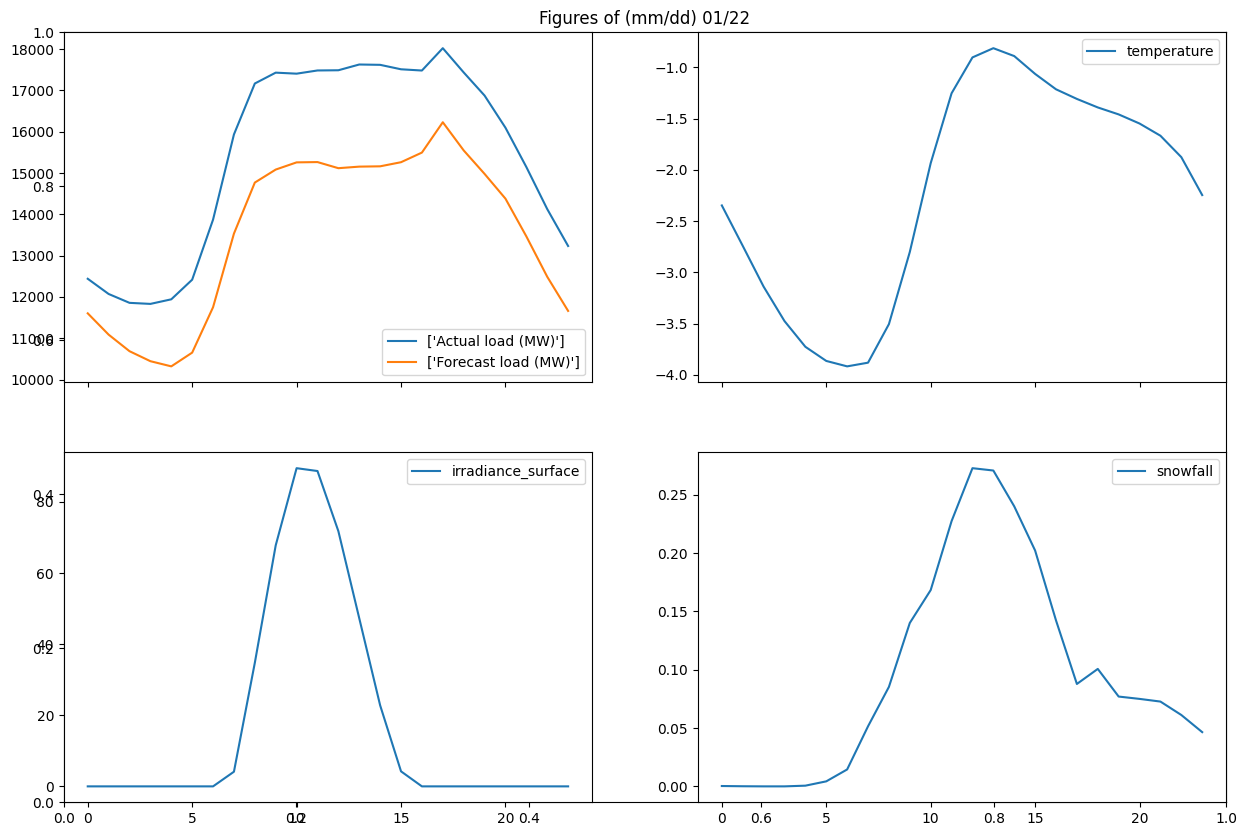

In [6]:
max_load_day_df = Input[(Input["month"] == max_month) & (Input["day"]==max_day)]

figure=plt.figure(figsize=(15,10))
plt.title(f"Figures of (mm/dd) {max_month:02}/{max_day:02}")
axs = figure.subplots(2, 2,sharex='all')

axs[0, 0].plot(max_load_day_df['hours'], max_load_day_df['Actual load (MW)'], label = ["Actual load (MW)"])
axs[0, 0].plot( max_load_day_df['hours'], max_load_day_df['Forecast load (MW)'], label = ["Forecast load (MW)"])
axs[0, 0].legend()

axs[0, 1].plot( max_load_day_df['hours'], max_load_day_df['temperature'], label = 'temperature')
axs[0, 1].legend()

axs[1, 0].plot( max_load_day_df['hours'], max_load_day_df['irradiance_surface'], label = 'irradiance_surface')
axs[1, 0].legend()

axs[1, 1].plot( max_load_day_df['hours'], max_load_day_df['snowfall'], label = 'snowfall')
axs[1, 1].legend()

plt.show()

The process of training a machine learning model relies on data or features. Properly prepared features are essential for learning. Real life applications requires knowledge on data and models, this process is called as feature engineering which will be covered in CodeLab 4. In this CodeLab, you will work on these 3 different feature matrices X_1, X_2, and X_3. Use the following pickle command to load the dictionary "D" which contains features and the target variable. 
<br> -Print the keys of dictionary with ".keys()" function.
<br> -Extract the contents of the dictionary in following variables X_1, X_2, C, and y.


In [7]:
D = pickle.load(open('file.pkl', 'rb'))
print(D.keys()) #prints keys

dict_keys(['Feature1', 'Feature2', 'Categorical', 'Target'])


In [8]:
y = D['Target']
X_1 = D['Feature1']
X_2 = D['Feature2']
C = D['Categorical']


"Feature1" (X_1) contains previous load demand and weather predictions. "Feature2" (X_2) has the full content of "Feature1" and the load forecast values from Entso-E. "Categorical" (C) features represent the categorical time element of the data in a one-hot encoded way. For example, C[i]=[100001100] represents data is taken from a weekend in the fall season and a daytime (07:00-16:00) load. Details regarding one-hot encoding and the structure of C is included in the bonus task of CodeLab. "Target" contains the target variable (y) of the ML model. Further details are explained in the PDF document. 
<br> -Calculate the sparsity of X_1, X_2, and C. 

In [9]:
Input.columns

Index(['day', 'month', 'hours', 'precipitation', 'temperature',
       'irradiance_surface', 'irradiance_toa', 'snowfall', 'snow_mass',
       'cloud_cover', 'air_density', 'Forecast load (MW)', 'Actual load (MW)',
       'Positive imbalance price (Eur/MWh)',
       'Negative imbalance price (Eur/MWh)'],
      dtype='object')

In [10]:
col = ['precipitation', 'temperature','irradiance_surface', 'irradiance_toa', 'snowfall', 'snow_mass','cloud_cover', 'air_density', 't-5', 't-6', 't-7', 't-8', 't-24','ENTSO-E', 'WE', 'mid week', 'winter','spring','summer','automn', 'mid-day', 'evening', 'night']
start_day = 10
duration = 1
def my_plot(X, col = ""):
    nb = X.shape[1]
    col = [i for i in range(nb)] if col == "" else col
    fig = plt.figure(figsize=(20,20))
    axes = fig.subplots(X.shape[1], 2)
    for i in range(nb):
        label = f"{col[i] if i<len(col) else i}"
        axes[i,0].plot(X[24*start_day:24*(start_day+duration),i], label=label)
        axes[i,1].plot(X[:,i], label=label)
        axes[i,0].legend()
        axes[i,1].legend()
    plt.show()

In [11]:
def sparsity(ar) -> float:
    return 0 if ar.size == 0 else 1 - len(ar.nonzero()[0])/ar.size
    
sparsity_X1 = sparsity(X_1)
sparsity_X2 =  sparsity(X_2)
sparsity_C =  sparsity(C)

print (f"Sparsity of \n\tX_1: {sparsity_X1:.0%}\n\tX_2: {sparsity_X2:.0%}\n\tC: {sparsity_C:.0%}")

Sparsity of 
	X_1: 22%
	X_2: 20%
	C: 67%


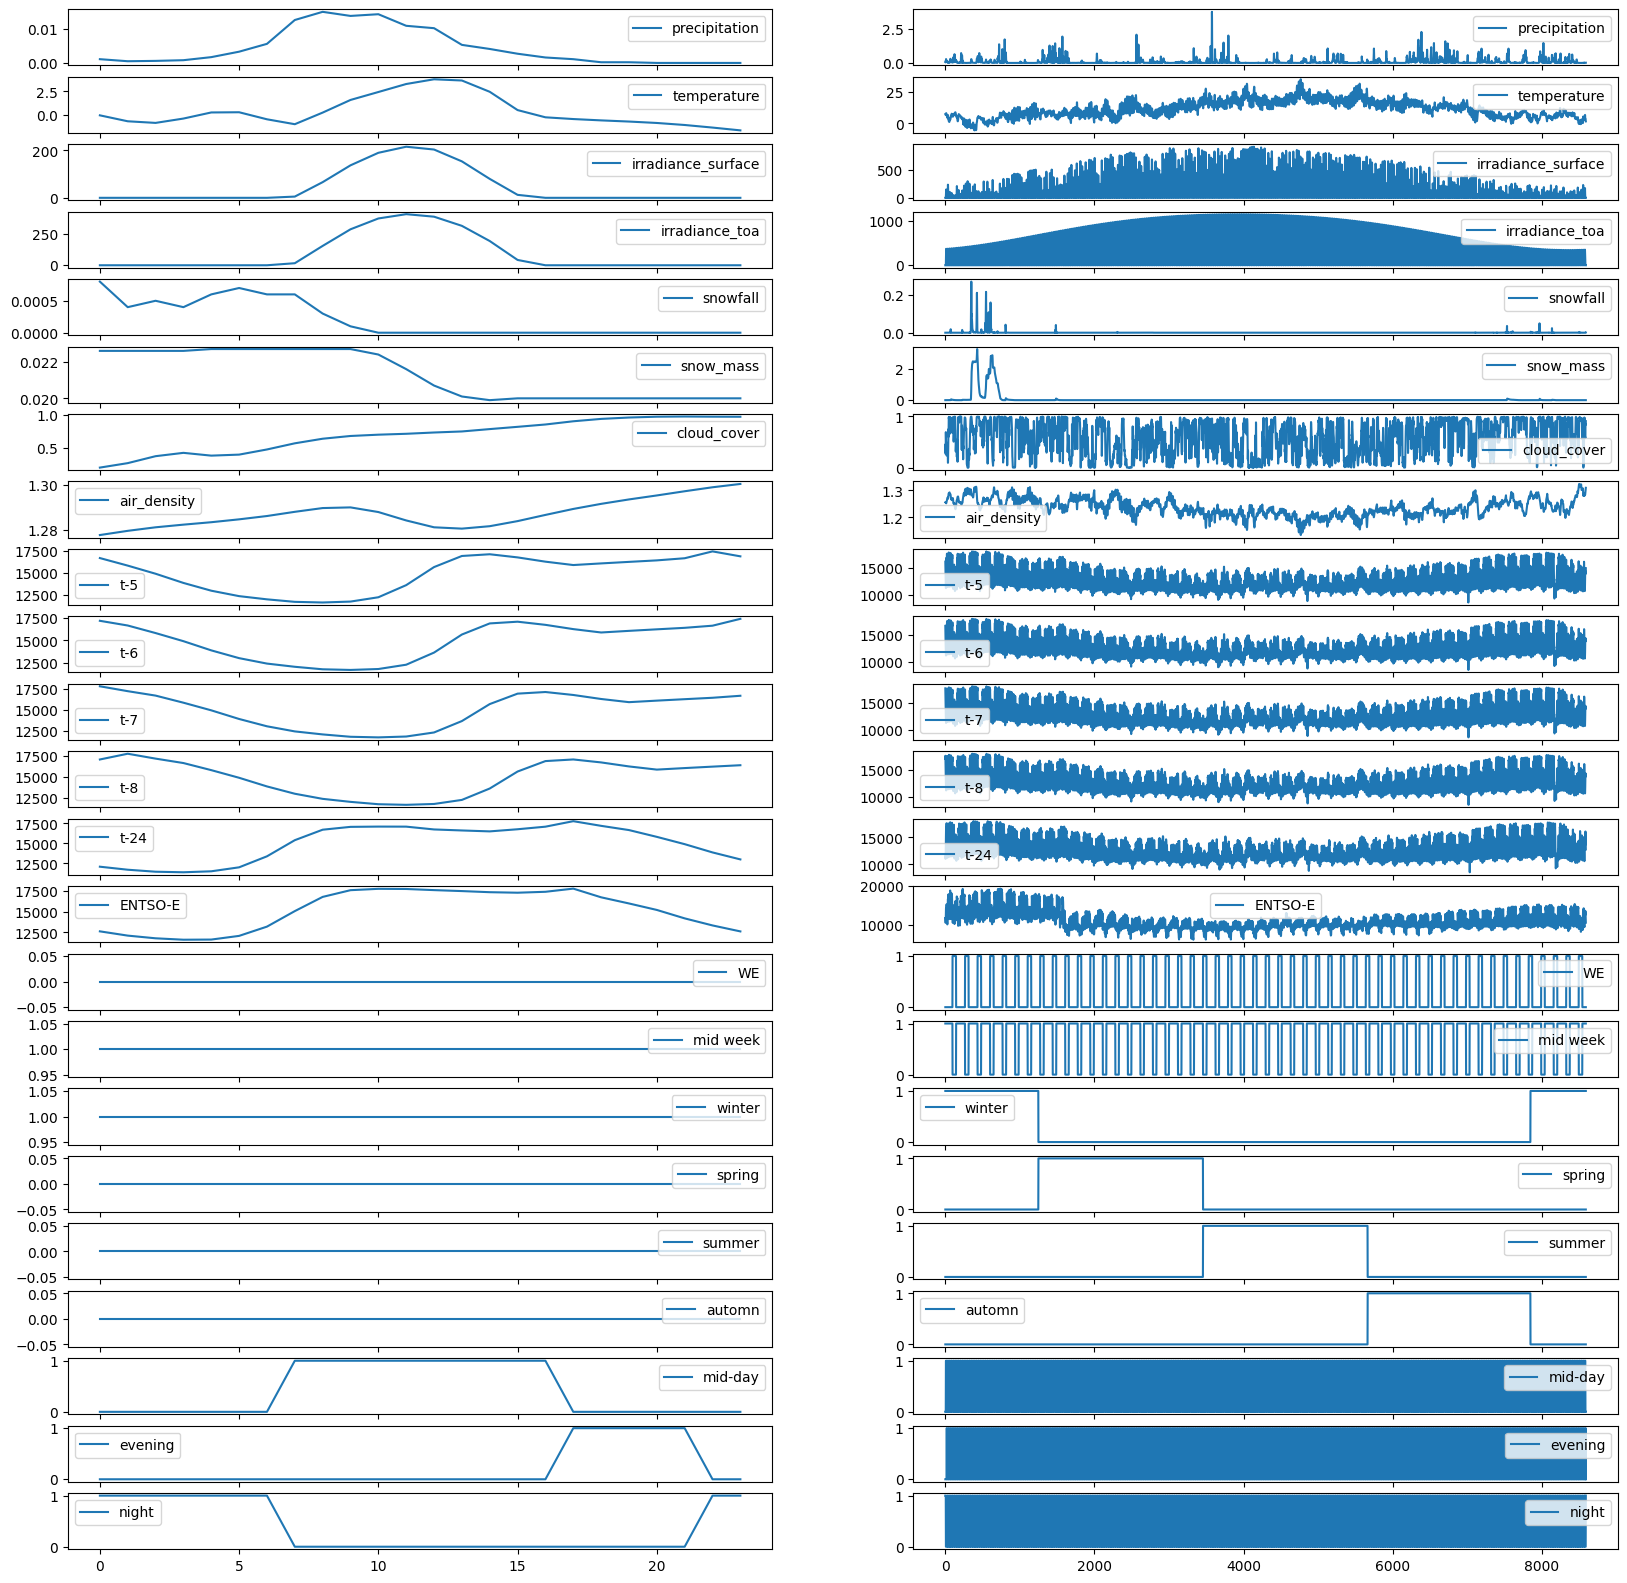

In [12]:
X_3 = np.concatenate((X_2, C), axis=1)
my_plot(X_3, col)

#### Questions
**<br>1)  What is the difference between the forecasted and actual loads at the hour of the maximum consumption?**
    
The difference between the forecasted and actual load is: -1792.5 which represents -10% (the forecasted load is 10% less than the actual one)

**<br>2)  What do you observe from the generated subplots?**

The actual and the forecasted loads have the same shape.

The temperature has a look a bit similar the load: not the same scale, smoother, and delayed

**<br>3)  Which features in the subplots might be good features for the machine learning model and why?**

As mentioned before, the temperature seems to be a good candidate. But it does not perfectly fit the pattern of the load.

The view of the subplot suggests that the time in the day is very important. One can also consider the day of week, and the date that are very important as they reflect the activity of the area (dinner time, work, ...) which have a great influence on the pattern of the load, then the magnitude is influenced by the temperature, the irradiance, snowfall...

It would be helpful to see the same time of many dates to identify which predictor is to be used.

**<br>4)  Calculate and write the sparsity of C.**

$$ Sparsity(C) = \frac{nbOfZeros(C)}{size0f(C)} \approx 67\% $$ 

**<br>5)  Explain why to use encoding instead numeric date values in a regression problem.**

The Encoding values are used for categorical values where the numeric value has no meaning, or even worse could be misleading. The bonus task mentionned the example the day of the month: January 31st and February 1st have a huge difference while have neighboring days.

**<br>6)  Explain why we need the time information for the load forecast problem.**

The time is important :
- the date reflects the season in the year: the consumption is influenced by the heating, the AC, the economic activity, and the length of the day
- Worked / non worked (week-end, bank holidays) days can be deduced from the date 
- the load is influenced by the time in the day: on average, in one region, the activity of the people is about the same at the same time (one shall distinguish worked/ non worked days)

**<br>7)  Why is it important to calculate sparsity? What does it mean to have a high/low sparsity and how it would affect the regression?**

Sparsity reflects the proportion of zeros in the feature matrix.

For a *numeric feature*, having a high sparsity means some features have a lots of zeros and would influence the target on a low proportion of datapoints. Therefore, the training data that will catch the influence of these fetaures is reduced, and their contribution factor will be less acturate than for the features for which more data are available. In our case, this concerns for example the features related to snow. Some episodes of snow that are recorded, but very few datapoints compare to the whole series. The lower the sparsity, the better.

In the other hand, a *categorical feature* which takes binary values should have a balanced sparsity: 50% means the training data have exactly the same numbre of datapoints with the feature on and with the feature off, which is ideal to grasp its influence.

# Task 2: Process data and prepare for machine learning algorithms

In this task, you will generate all feature sets and standardize or scale the data for the training process. 

<br>The standardization process is essential for many machine learning models. For instance, many algorithms (such as the RBF kernel of Support Vector Machines) assume that all features are centered around 0 and have variance in the same order. If a feature has a variance that is orders of magnitude larger than others, it might dominate and make the estimator unable to learn from other features correctly as expected [Sklearn StandardScaler-https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html] . 

<br>Features are standardized by removing the mean and scaling to unit variance. This process is called standard scaling or z normalization. 

<br> z = (x-u)/s where u is the mean of feature and s is the standard deviation.

<br> -Use sklearn StandardScaler to scale X_1.
<br> -Define a new scaler to scale X_2.
<br> -Concatenate categorical variable matrix C to scaled X_2 which will generate the third feature set X_3. 
<br> X_1 = [Weather(t), Historical_demand(t-x)], X_2 = [X_1, Forecast], X_3 = [X_2scaled, C]

In [13]:
#Feature scaling
scaler1 = StandardScaler()
scaler2 = StandardScaler()
scaler3 = StandardScaler()
X_1scaled = scaler1.fit_transform(X_1)
X_2scaled = scaler2.fit_transform(X_2)
X_3 = np.concatenate((X_2scaled, C), axis=1)
X_3scaled =  scaler3.fit_transform(X_3)


The dataset must be split into training and test sets. 25% of the data will be used for test proposes. To generate reproducible results, please use the given Shuffle_state variable as a random state of the splitter function. Note: When you call the Shuffle_state, y_train, and y_test (target variables) from different splits will be the same.
<br>-Split X_1, X_2 and X_3 using Sklearn train_test_split() function into 3 training and 3 test data
<br>-Print out the mean of X_1, scaled X_1, training data X_1 (scaled), and test data X_1 (scaled).

In [14]:
#Train test split
Test_ratio = 0.25
Shuffle_state = 4720
X_train1, X_test1, y_train, y_test = train_test_split(X_1scaled, y, test_size=Test_ratio, random_state=Shuffle_state)

X_train2, X_test2, y_train, y_test = train_test_split(X_2scaled, y, test_size=Test_ratio, random_state=Shuffle_state)

X_train3, X_test3, y_train, y_test = train_test_split(X_3scaled, y, test_size=Test_ratio, random_state=Shuffle_state)

print("Mean of X_1 = %.3f"%np.mean(X_1))
print("Mean of scaled X_1 = %.3f"%np.mean(X_1scaled))
print("Mean of scaled X_train1 = %.3f"%np.mean(X_train1))
print("Mean of scaled X_test1 = %.3f"%np.mean(X_test1))

Mean of X_1 = 5030.273
Mean of scaled X_1 = 0.000
Mean of scaled X_train1 = -0.001
Mean of scaled X_test1 = 0.004


#### Questions
**<br> 1) Why do you use 2 different scalers, what happens if the first one used for to scale X_2 as well?**

The scalers first fit the parameters (calculates the *means* and *standard deviation*) of the matrix of each column of the matrix.

- First, X_1 and X_2 have different dimensions, so this cannot be applicable
- moreover, if they had the same dimensions, they could have very different parameters in each of their column (which is not the case here as X_2 is build by adding a column to X_1).

**<br> 2) What is the mean of X_1, scaled X_1, X_train1 and X_test1? Print out results.**

Mean of
- X_1 = 5030.273
- scaled X_1 = 0.000
- scaled X_train1 = -0.001
- scaled X_test1 = 0.004

Mean of Scaled X_1 is 0, which is the purpose of the scaling.

If we make a weighted average using the Test_ratio (1/4). We have $Test\_ratio * \overline{scaled\ X\_train1} + (1-Test\_ratio) * \overline{scaled\ X\_test1} = 0$

**<br> 3) Why categorical variables are not scaled?**

It does not make sense to calculate a mean of a categorical variable.

# Task 3: Training and evaluation of linear regressors

In this CodeLab, different regression models are implemented. Using linear regression models, you should identify the best feature set to investigate further. After the most appropriate feature set is identified, regularization on linear regression is investigated through Ridge and Lasso models.

#### Linear Regression:
-Construct and train three linear regression models using feature sets X_1, X_2 and X_3.
<br> -Define a function test_mymodel(model,X_test,y_test) to evaluate the model performance. Function takes model, test features and test target variable (label), output is R2 score and MSE. 
<br> -Evaluate models with test_mymodel and record the output.

In [15]:
#Linear regression models
lin_reg_1 = LinearRegression().fit(X_train1, y_train)
lin_reg_2 = LinearRegression().fit(X_train2, y_train)
lin_reg_3 = LinearRegression().fit(X_train3, y_train)

In [16]:
#Model evaluation function
def test_mymodel(model,X,y):
    RSS = sum((y1 - y2)**2 for y1, y2 in zip(model.predict(X), y))
    MSE = RSS / len(y)
    mean = np.mean(y)
    TSS = sum((y1 - mean)**2 for y1 in y)
    R2 = 1 - RSS / TSS
    return MSE, R2

In [17]:
#Comparison of different feature sets
def append_indicators(model, X, Y, MSE, R2):
    mse, r2 = test_mymodel(model,X, Y)
    MSE.append(mse)
    R2.append(r2)

MSE=[]; R2=[]
append_indicators(lin_reg_1, X_test1, y_test, MSE, R2)
append_indicators(lin_reg_2, X_test2, y_test, MSE, R2)
append_indicators(lin_reg_3, X_test3, y_test, MSE, R2)

print("MSE scores of linear regressors: "+str(MSE))
print("R2 scores of linear regressors: " +str(R2))

MSE scores of linear regressors: [928883.9611758309, 622490.3838241048, 421128.61456144566]
R2 scores of linear regressors: [0.7511760412272823, 0.8332509462161521, 0.8871905497270035]


 -Plot  2 bar graphs for R2 and MSE of all linear regression models (Hint: use plt.ylim() to adjust limits for better visuals). 
<br> -Plot all predictions and test data together for the first 64 hours or between [0:64] sample points.
<br> -Print out the weigths of the best model and find the absolute maximum difference between weights. 

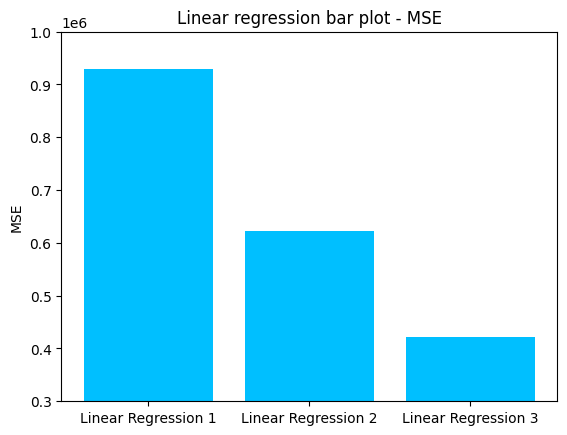

In [18]:
#MSE bar plot for linear regression 
low = 3e5
high = 1e6
name = ["Linear Regression 1", "Linear Regression 2", "Linear Regression 3"]
plt.ylabel('MSE')
plt.title("Linear regression bar plot - MSE" )
plt.bar(name, MSE,color='deepskyblue')
plt.ylim(low,high)
plt.show()

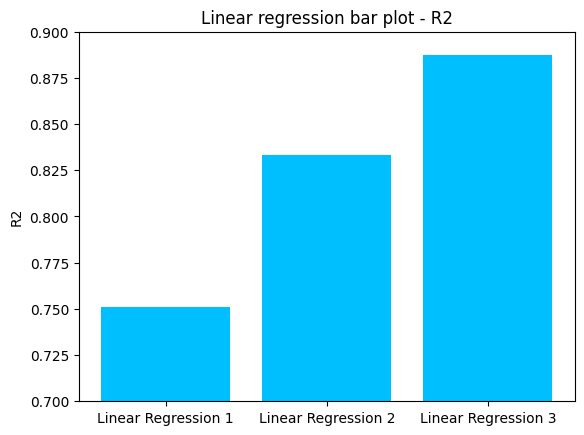

In [19]:
#R2 bar plot for linear regression 
low = .7
high = .9
name = ["Linear Regression 1", "Linear Regression 2", "Linear Regression 3"]
plt.ylabel('R2')
plt.title("Linear regression bar plot - R2" )
plt.bar(name, R2,color='deepskyblue')
plt.ylim(low,high)
plt.show()

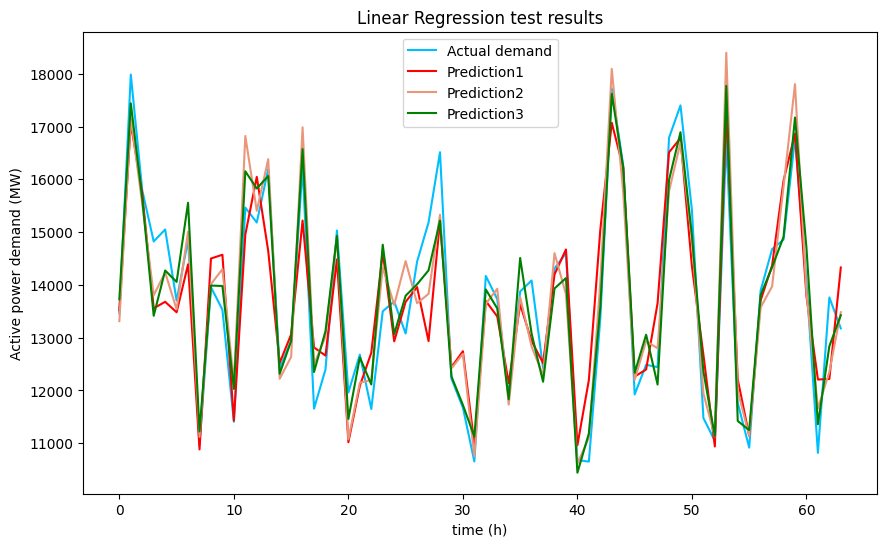

In [20]:
#Time series plot of prediction 
lin_predict_1 = lin_reg_1.predict(X_test1[:64])
lin_predict_2 = lin_reg_2.predict(X_test2[:64])
lin_predict_3 = lin_reg_3.predict(X_test3[:64])
plt.figure(figsize=(10.24,6.00))
plt.plot(y_test[:64], c='deepskyblue',label='Actual demand')
plt.plot(lin_predict_1, c='r',label='Prediction1')
plt.plot(lin_predict_2, c='darksalmon',label='Prediction2')
plt.plot(lin_predict_3, c='g',label='Prediction3')

plt.xlabel('time (h)') 
plt.ylabel('Active power demand (MW)')
plt.title("Linear Regression test results")
plt.legend()
plt.show()

In [21]:
#Print coeffients
coef = lin_reg_3.coef_ 
print(coef)
print("\n Absolute difference = %.2f" %(max(coef) - min(coef)))

[ 1.72164295e+01 -3.34910251e+02 -4.78114187e+02  5.52206553e+02
  2.46489748e+01 -2.03312658e+01  2.24376088e+01 -1.32246418e+02
  1.00628187e+03 -1.03792383e+03  1.73418669e+02  8.84686755e+01
  5.22959720e+02  6.74526311e+02 -8.87654630e+13 -8.87654630e+13
  2.08812608e+15  2.16215118e+15  2.16215118e+15  2.15440650e+15
  2.81921169e+15  2.32233823e+15  2.76841092e+15]

 Absolute difference = 2907977150285209.00


#### Ridge & Lasso Regression:
Ridge & Lasso regression models are modified forms of linear regression. The complexity parameter alpha controls the complexity of the model. Adjust the alpha parameter to obtain the best results. Although alpha in both models adjusts the regularization in the optimization problem, their mathematical interpretations are different so same alpha values will have different effects in training. 
<br> -Train ridge and lasso regression models with alpha=0.1, using the best performing feature set in linear regression.
<br> -Test both models with test_mymodel() and record R2 and MSE values.
<br> -Train and test both models again with varying alpha values starting from 0.0005 to 1.0 with a step size equal to 0.005. Record R2 and MSE at each step.
<br> -Plot "alpha vs MSE" and "alpha vs R2" to find the best performing regularization parameter alpha and its effect on prediction.

Ridge and Lasso models construct an optimization problem, therefore for numerical stability we have scaled the target variable as well with the following code block. Please use the new y_train_s and y_test_s to fit and test models. Otherwise, convergence problems might be observed.

In [22]:
u = np.mean(y_train)
s = np.std(y_train)
y_train_s = (y_train-u)/s
y_test_s = (y_test-u)/s

In [23]:
lin_reg_3_s = LinearRegression().fit(X_train3, y_train_s)
test_mymodel(lin_reg_3_s, X_test3, y_test_s)

(0.11425885804588616, 0.8872025026162516)

In [24]:
#Ridge & Lasso Regression
Rid_reg = Ridge(.1)
Las_reg = Lasso(.1)

Rid_reg.fit(X_train3, y_train_s)
Las_reg.fit(X_train3, y_train_s)

MSE_rid, R2_rid= test_mymodel(Rid_reg, X_test3, y_test_s)
MSE_las, R2_las = test_mymodel(Las_reg, X_test3, y_test_s)
print("MSE scores of ridge regressor: %.2f"%(MSE_rid))
print("MSE scores of lasso regressor: %.2f"%(MSE_las))
print("R2 scores of ridge regressors: %.5f"%(R2_rid))
print("R2 scores of lasso regressors: %.5f"%(R2_las))

MSE scores of ridge regressor: 0.11
MSE scores of lasso regressor: 0.17
R2 scores of ridge regressors: 0.88722
R2 scores of lasso regressors: 0.83579


Note that y_train_s is scaled, and the MSE can not be compared to the MSEs of the previous section

In [25]:
max(abs(Rid_reg.coef_)), max(abs(Las_reg.coef_))

(0.541020498396162, 0.37291136649736717)

In [26]:
#Effect of alpha
def record_indicators(model, X_train, Y_train, X_test, Y_test, alphas):
    MSE_rec = []
    R2_rec = []
    for alpha in alphas:
        mod = model(alpha)
        mod.fit(X_train, Y_train)
        append_indicators(mod, X_test, Y_test, MSE_rec, R2_rec)
    return MSE_rec, R2_rec

alphas = list(np.arange(.005, 1.001, .005))
MSE_record_ridge, R2_record_ridge = record_indicators(lambda a:Ridge(a), X_train3, y_train_s, X_test3, y_test_s, alphas)
MSE_record_lasso, R2_record_lasso = record_indicators(lambda a:Lasso(a), X_train3, y_train_s, X_test3, y_test_s, alphas)

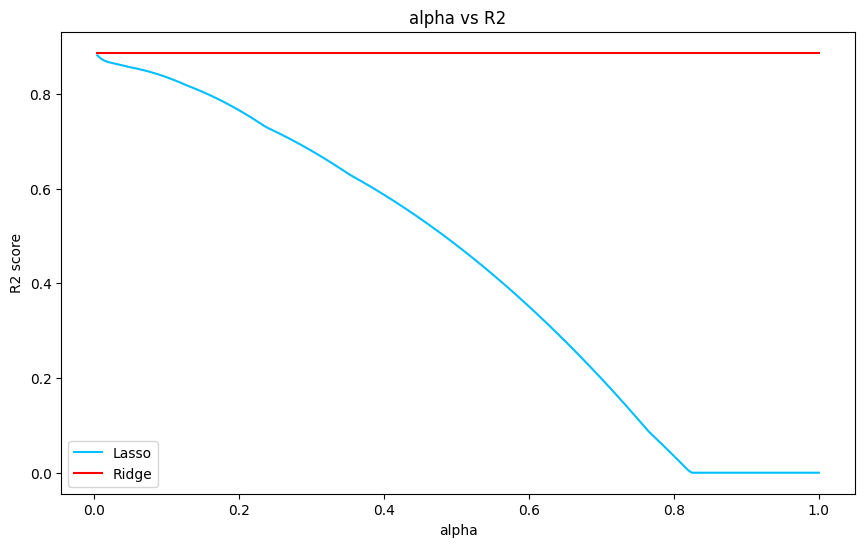

In [27]:
#Alpha vs R2
plt.figure(figsize=(10.24,6.00))
plt.plot(alphas, R2_record_lasso ,c='deepskyblue',label='Lasso')
plt.plot(alphas, R2_record_ridge , c='r',label='Ridge')
plt.xlabel('alpha') 
plt.ylabel('R2 score')
plt.title("alpha vs R2")
plt.legend()
plt.show()

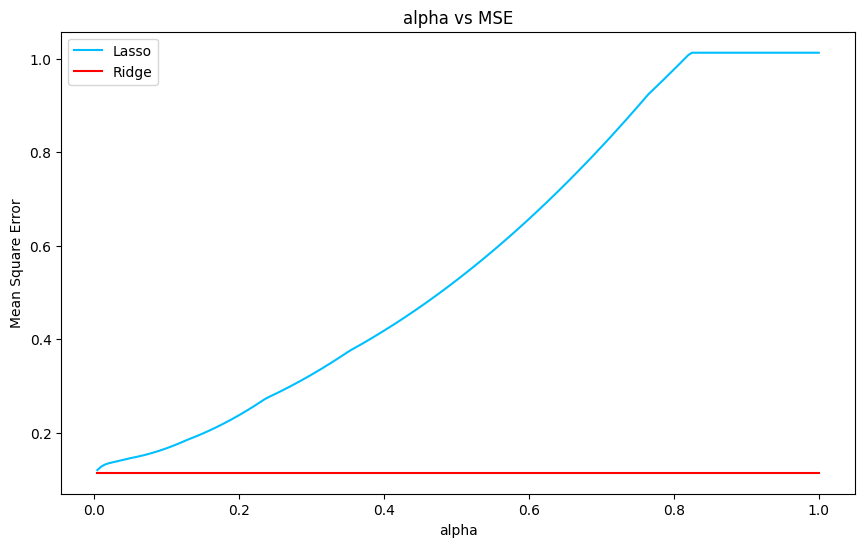

In [28]:
#Alpha vs MSE
plt.figure(figsize=(10.24,6.00))
plt.plot(alphas, MSE_record_lasso ,c='deepskyblue',label='Lasso')
plt.plot(alphas, MSE_record_ridge, c='r',label='Ridge')
plt.xlabel('alpha') 
plt.ylabel('Mean Square Error')
plt.title("alpha vs MSE")
plt.legend()

#### Questions
**<br> 1)	Record R2 and MSE scores of linear regression models, compare and comment on the results.**

| Feature set  |     MSE     |    R2    |
|--------------|------------|----------|
|     X_1      | 928,884    | 0.7512   |
|     X_2      | 622,490    | 0.8333   |
|     X_3      | 421,129    | 0.8872   |

Which indicates the quality of regression based on X_3 has the highest quality, and X_1 the lowest.
- Adding the forecasts of entso-e seems to help in X_2 compare to X_1: this is probably a good quality feature.
- X_3 is better still, adding the categorical value helps in differentiating the load pattern.

**<br> 2)	What does MSE represent for the linear regression problem in this CodeLab?**
The MSE represents the mean square error of the regression of the normalized feature sets. The MSE of the load forecast should be calculated after inverting the scaling.

**<br> 3)	Which feature set gives the best prediction capability?**

According to the analysis in question 1, X_3 gives the best prediction capability.    

**<br> 4)	What is the absolute difference between the maximum and minimum weights of the best performing model?**
The absolute difference = 2,9e15

**<br> 5)	What do weights correspond to in a linear regression?**
Each weight corresponds to a feature. When predicting the output, each feature is multiplied by its corresponding weight. When the dataset is normalized, the weight reflects the contribution of the feature to the prediction.

**<br> 6)	What is the role of alpha in Ridge and Lasso models?**
In Ridge and Lasso regression, the cost function contains the RSS and a function (L1 or L2) reflecting the weights of the regression multiplied by alpha. If the weights grow, the cost function - that is to be minimized - grows. Therefore, these regressions foster low weights.

Thus, alpha is the factor that is multiplying the contribution of the weight to the Ridge or Lasso regression. The bigger alpha, the more the concern of shrinking the coefficient is taken into account.

**<br> 7) Why is the MSE of Ridge & Lasso a thousand times smaller than the linear regression?**

Because they trained and tested with a scaled output data.

**<br> 8)	Compare the results of regularized models with previous linear regressors.**

Their performances (MSE and R2) look very similar. But the coefficients all shrink very well. With alpha = 0.1, the biggest absolute coefficients are : Ridge: 0.54, Lasso: 0.37.

**<br> 9) What is the value of alpha that gives the smallest error in the test set?**

According to the present experiment, the lowest value (0.005) presents the best results.

- With the explored alpha values: the indicators for the *Ridge* regression are steady, and reflect a good quality of the regression (R2 close to .9 and MSE around to 0.1). Deeper analysis is proposed at the end of this codeLab.
- For the *Lasso* regression, one can observe in that window the indicator is changing. With the lowest value, the indicators reflect a good quality of the regression. Above alpha~=0.8, the regression quality is very bad: the lasso coefficients are all equal to 0.


# Task 4: Support Vector Machine

Support vector machines (SVMs) are supervised machine learning methods used for classification, regression and outliers detection.  This technique will be introduced in week 3. However, now you can treat it as a black box and try to play with it. If you are eager to find out what it is and how it works, this link may help you.

https://medium.com/cube-dev/support-vector-machines-tutorial-c1618e635e93


In this practicum SVM is investigated with different parameters and kernels. Kernels are decision functions which have been applied to transform the feature space into higher dimensions. Nonlinear relationships between features can be found in high dimensional space. 
<br> Compared to linear models construction of SVM is much more expensive. Time library can be utilized the measure the training time of SVM. For this task, please use again the scaled target variables for numerical stability. 
<br> -Construct a linear SVM regressor with default parameters and record R2, MSE and training time.
<br> Note: Add maximum iteration as 1e6 or 1e7 inside the model definition to avoid long training times.

In [29]:
#Time measurement 
#Put the start value at the beginning of the cell and put stop value at the end of the cell.
start = time.time()
stop = time.time()
print("Required Time= "+str(stop-start))

Required Time= 1.0967254638671875e-05


In [30]:
#Linear SVM
start = time.time()
svm_lin = SVR().fit(X_train3, y_train_s)
MSE_svmlin, R2_svmlin= test_mymodel(svm_lin, X_test3, y_test_s)
print("MSE scores of linear SVM: "+str(MSE_svmlin))
print("R2 scores of linear SVM: "+str(R2_svmlin))
stop = time.time()
print("Required Time for linear SVM seconds= "+str(stop-start))

MSE scores of linear SVM: 0.04260978622028797
R2 scores of linear SVM: 0.9579351891669107
Required Time for linear SVM seconds= 1.0085170269012451


 -Conduct a grid search (apply all possible pairs) on C and epsilon with the given list of parameters. 
 
 <br>The model parameters that gives the highest R2 or the lowest MSE score will be used in next SVM models. (It is possible to observe different set of parameters for the lowest MSE and the highest R2. Please select one performance metric to find the most suitable hyperparameters.)
 
 <br>Hint: The grid search process can be done by nested loops. Construct 2 for loops to iterate each hyperparameter and train with different parameter combinations at each iteration. Lists are useful for recording performance metrics.

In [31]:
#SVM Grid search
start = time.time()

Regularization_list = [0.01, 0.1, 1, 5]
epsilon_list = [0.01, 0.1, 1, 5]

MSE_rec = [] ; R2_rec = []; C_rec = []; epsilon_rec=[]
for c in Regularization_list:
    for eps in epsilon_list:
        model = SVR(C=c, epsilon=eps).fit(X_train3, y_train_s)
        append_indicators(model, X_test3, y_test_s, MSE_rec, R2_rec)
        C_rec.append(c)
        epsilon_rec.append(eps)
        
stop = time.time()
print("Required Time= "+str(stop-start))

Required Time= 11.853001117706299


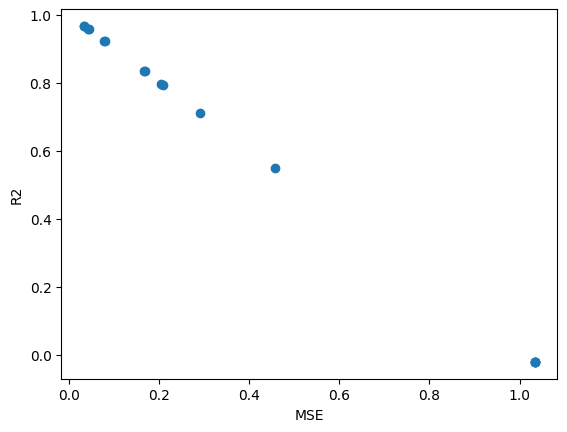

In [32]:
plt.plot(MSE_rec, R2_rec, 'o')
plt.xlabel('MSE')
plt.ylabel('R2')
plt.show()

The best R2 coincides with the best MSE.

In [33]:
#Find best parameters
max_R2 = max(R2_rec)
max_R2_ind = R2_rec.index(max_R2)
C_best = C_rec[max_R2_ind]
epsilon_best = epsilon_rec[max_R2_ind]

-Write and compare results of default and tuned linear SVMs. Print selected parameters and performance metrics. 

In [34]:
print("Best R2:", max_R2)
print("Best C:", C_best)
print("Best epsilon:",epsilon_best)
print("MSE scores of linear SVM default: "+str(MSE_svmlin))
print("R2 scores of linear SVM default: "+str(R2_svmlin))
print("MSE scores of linear SVM best: "+str( MSE_rec[max_R2_ind]))
print("R2 scores of linear SVM best: "+str(R2_rec[max_R2_ind]))

Best R2: 0.9679320989488981
Best C: 5
Best epsilon: 0.01
MSE scores of linear SVM default: 0.04260978622028797
R2 scores of linear SVM default: 0.9579351891669107
MSE scores of linear SVM best: 0.03248336034940506
R2 scores of linear SVM best: 0.9679320989488981


-Construct a polynomial SVM regressor with best regressor parameters identified in the previous task, default settings for the other parameters(gamma=auto, degree=3, etc.). Record R2, MSE and training time.

In [35]:
#Polynomial SVM- auto gamma
start = time.time()
svm_poly1 = SVR(kernel = 'poly', C=C_best, epsilon=epsilon_best, gamma='auto')
svm_poly1.fit(X_train3, y_train_s)
MSE_svmpoly1, R2_svmpoly1= test_mymodel(svm_poly1, X_test3, y_test_s)
print("MSE scores of polynomial SVM: "+str(MSE_svmpoly1))
print("R2 scores of polynommial SVM: "+str(R2_svmpoly1))
stop = time.time()
print("Required Time for polynomial SVM = "+str(stop-start))

MSE scores of polynomial SVM: 0.04546248408998208
R2 scores of polynommial SVM: 0.9551189770499978
Required Time for polynomial SVM = 7.050376892089844


-Adjust the gamma parameter from 'auto' to 'scale', observe the effect by measuring time and test scores. Print results of auto and scaled gamma parameters for polynomial SVM. 

In [36]:
#Polynomial SVM- scaled gamma
start = time.time()
svm_poly2 = SVR(kernel = 'poly', C=C_best, epsilon=epsilon_best, gamma='scale')
svm_poly2.fit(X_train3, y_train_s)
MSE_svmpoly2, R2_svmpoly2= test_mymodel(svm_poly2, X_test3, y_test_s)
print("MSE scores of polynomial SVM: "+str(MSE_svmpoly2))
print("R2 scores of polynommial SVM: "+str(R2_svmpoly2))
stop = time.time()
print("Required Time for polynomial SVM = "+str(stop-start))

MSE scores of polynomial SVM: 0.04544560261355111
R2 scores of polynommial SVM: 0.9551356426138422
Required Time for polynomial SVM = 7.440562963485718


-Construct a RBF SVM regressor with best performing hyperparameters from the polynominal SVM, and record R2, MSE.

In [37]:
#Gaussian SVM
svm_gaus = SVR(kernel = 'rbf', C=C_best, epsilon=epsilon_best, gamma='scale')
svm_gaus.fit(X_train3, y_train_s)
MSE_svmgaus, R2_svmgaus= test_mymodel(svm_gaus, X_test3, y_test_s)
print("MSE scores of Gaussian SVM: "+str(MSE_svmgaus))
print("R2 scores of Gaussian SVM: "+str(R2_svmgaus))

MSE scores of Gaussian SVM: 0.03248336034940506
R2 scores of Gaussian SVM: 0.9679320989488981


 -Change the kernel scale gamma using the given kernel scale set, measure time and performance of the optimization problem.

In [38]:
#Gaussian SVM kernel search
Kernel_scale = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4]
MSE_rec_gaus = []; R2_rec_gaus = []
for gam in Kernel_scale:
    svm_gaus2 = SVR(kernel = 'rbf', C=C_best, epsilon=epsilon_best, gamma=gam)
    svm_gaus2.fit(X_train3, y_train_s)
    append_indicators(svm_gaus2, X_test3, y_test_s, MSE_rec_gaus, R2_rec_gaus)
print("MSE ",MSE_rec_gaus)
print("R2 ",R2_rec_gaus)

MSE  [0.05213887058088759, 0.03134122819732213, 0.028204046578444532, 0.03381640293089918, 0.04011032785335548, 0.04821161844349021]
R2  [0.9485279809502611, 0.9690596233320381, 0.9721566806762099, 0.9666161058638095, 0.9604026796829775, 0.9524050038810827]


-Plot gamma vs R2 and gamma vs MSE. Optional: You can plot the prediction and truth together.

Text(0.5, 1.0, 'RBF SVM - γ effect')

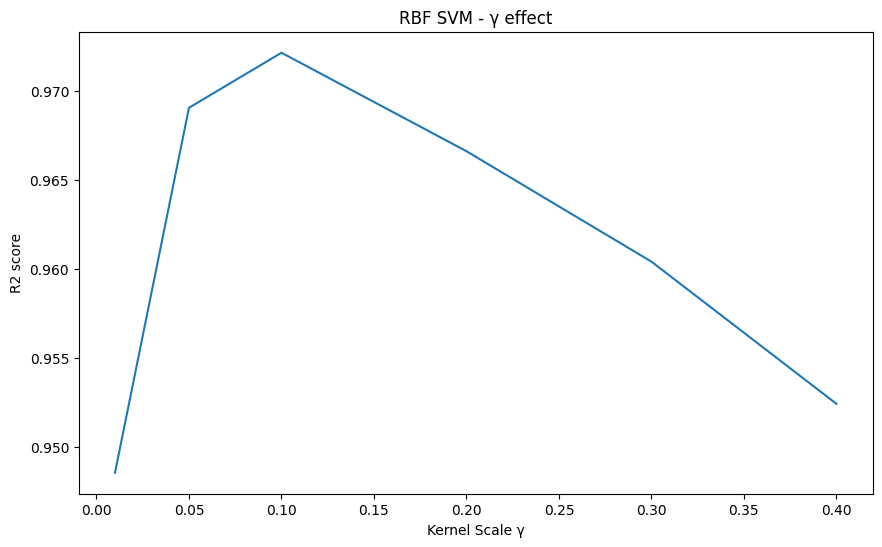

In [39]:
#Gamma vs R2 plot
plt.figure(figsize=(10.24,6.00))
plt.plot(Kernel_scale, R2_rec_gaus)
plt.xlabel('Kernel Scale γ') 
plt.ylabel('R2 score')
plt.title("RBF SVM - γ effect")


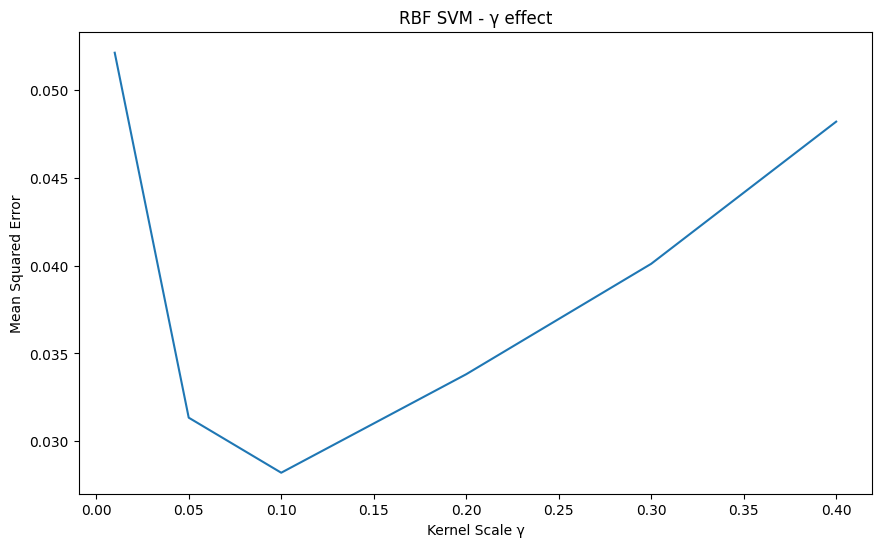

In [40]:
#Gamma vs MSE plot
plt.figure(figsize=(10.24,6.00))
plt.plot(Kernel_scale, MSE_rec_gaus)
plt.xlabel('Kernel Scale γ') 
plt.ylabel('Mean Squared Error')
plt.title("RBF SVM - γ effect")
plt.show()


Optional: Find and tune the best SVM model for the regression problem, you can find better model than solution manual. Solution key R2=0.9762 & MSE=0.02406

In [41]:



#Gaussian SVM
svm_gaus = SVR(kernel = 'rbf', C=C_best, epsilon=epsilon_best, gamma=0.1)
svm_gaus.fit(X_train3, y_train_s)
MSE_svmgaus, R2_svmgaus= test_mymodel(svm_gaus, X_test3, y_test_s)
print("MSE scores of polynomial SVM: "+str(MSE_svmgaus))
print("R2 scores of polynommial SVM: "+str(R2_svmgaus))

MSE scores of polynomial SVM: 0.028204046578444532
R2 scores of polynommial SVM: 0.9721566806762099


#### Questions

**1) Write and compare results of default and tuned linear SVMs.**

|                  Model                  |    MSE    |    R2    |
|-----------------------------------------|-----------|----------|
|   Linear SVM                            |   0.043   |   0.958  |
|   Linear SVM tuned                      |   0.032   |   0.968  |

The tuned one is better than the default one. The grid search allows to identify the best fit among the combination of 2 parameters.

**<br>2) Write and compare results of auto and scaled gamma parameters for polynomial SVM.**

|                  Model                  |    MSE    |    R2    |
|-----------------------------------------|-----------|----------|
|   Polynomial SVM auto gamma             |   0.045   |   0.955  |
|   Polynomial SVM scaled gamma           |   0.045   |   0.955  |

The results look very similar. The auto gamma seams to run a bit faster, but this should be further investigated with multiple runs.

**<br>3) Write and compare results of different gamma values for RBF SVM.**

|                  Model                  |    MSE    |    R2    |
|-----------------------------------------|-----------|----------|
|   Gaussian SVM gamma 0.01               |   0.052   |   0.949  |
|   Gaussian SVM gamma 0.05               |   0.031   |   0.969  |
|   Gaussian SVM gamma 0.1                |   0.028   |   0.972  |
|   Gaussian SVM gamma 0.2                |   0.034   |   0.967  |
|   Gaussian SVM gamma 0.3                |   0.040   |   0.960  |
|   Gaussian SVM gamma 0.4                |   0.048   |   0.952  |

The best gamma is around 0.1, this could be refined considering the MSE curve and R2 curve look convex.

The C and epsilon parameters could also be fine-tuned to meet the best performances.

**<br>4) Which model (with parameters) has the highest performance in load forecast problem?**

Among the tested models, the Gaussian SVM with gamma = 0.1, C = 5 and epsilon = 0.01 has the highest performance in terms of accuracy.

#### Bonus Task
In this bonus task you have to implement a regression model that predicts the total electricity consumption of a day using only time information in a categorical form.

<br>Some data types cannot be represented as numeric values like day of the month. Entering numeric value of the day can cause last weeks of the month have larger impact on prediction which may affect the prediction capability of many machine learning models. Each numeric value can be transformed into binary representation.

<br>For example, colour of apples 'red' and 'green' can be codded with 2 binary vectors a1 and a2 where a1 represents whether apple is red or not, a2 shows green or not with binary values 1 and 0. ( a1[55]=1 , 56th sample point is a red apple which requires a2[55]=0 because it cannot be both red and green at the same time.)
3 different categorical variables are used to model the time element. Matrix C has a shape of 8592*9. Each coloumn contains a specific categorical binary value. Order of columns in matrix C must be identical with the same order given below.
	<br>a)Weekend and weekday
	<br>b)Seasons: Winter, Spring, Summer, Fall
	<br>c)Hours: Day (07:00-16:00), Peak (17:00-21:00), Night (22:00-06:00)
<br>C=[Weekend,Weekday,Winter,..,Fall,Day,..,Night]

<br>For this task create a new feature matrix or vector X_bonus from the given Input CSV file that can only contain time related features. After that create the vector y_day which contains the total daily consumption level. Finally, create your regressor model, train, and evaluate the model performance. Provide your observations and findings. 


### Digging in Ridge regression analysis
The steadiness of the figures of the Ridge regression for the explored span of alphas in the codeLab statement is questioning. Hereafter further analysis.

In [42]:
def assess_model(title, model, X_train, Y_train, X_test, Y_test, indexes, plot_MSE=True, plot_R2=True, plot_max=True):
    MSE_rec = []
    R2_rec = []
    max_rec = []
    for i in indexes:
        mod = model(i)
        mod.fit(X_train, Y_train)
        MSE, R2 = test_mymodel(mod, X_test, Y_test)
        MSE_rec.append(MSE)
        R2_rec.append(R2)
        max_rec.append(max(abs(mod.coef_)))
    fig, ax1 = plt.subplots()
    plt.title(title)
    ax1.set_xscale('log')
    first=True
    ax1.set_xlabel('alpha')
    if plot_max:
        first=False
        ax1.set_ylabel('max(abs(coefs))', color='green')
        ax1.plot(indexes, max_rec, color = 'green')
    if plot_MSE:
        ax2 = ax1 if first else ax1.twinx()
        first=False
        ax2.set_ylabel('MSE', color='blue')
        ax2.plot(indexes, MSE_rec, color = 'blue', label = "MSE")
    if plot_R2:
        ax3 = ax1 if first else ax1.twinx()
        first=False
        ax3.set_ylabel('R2', color='red')
        if not first: ax3.spines['right'].set_position(('outward', 40))
        ax3.plot(indexes, R2_rec, color = 'red', label = 'R2')
    plt.show()

rid = lambda i:Ridge(i)
las = lambda i:Lasso(i)

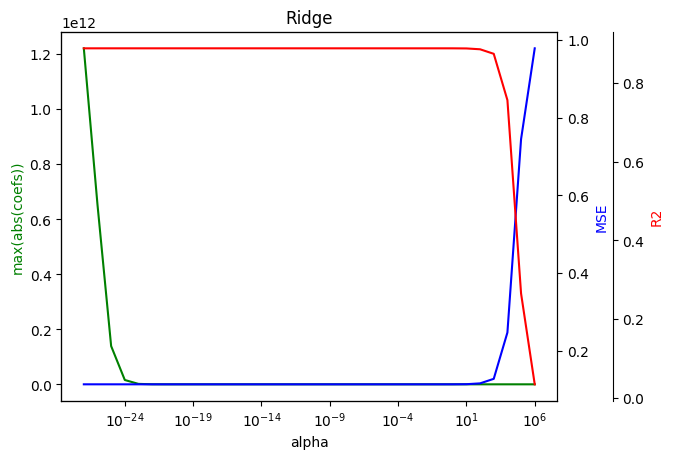

In [43]:
assess_model("Ridge",rid, X_train3, y_train_s, X_test3, y_test_s, [10 ** i for i in np.arange(-27, 7., 1)])


One can observe:
- the shrinkage is done with very small values of lambda (below $10^{-20}$)
- the MSE and R2 are deteriorating with high values of lambda (above $10^{2}$)
- in between, the regression indicators are good, and steady

Let us zoom in:

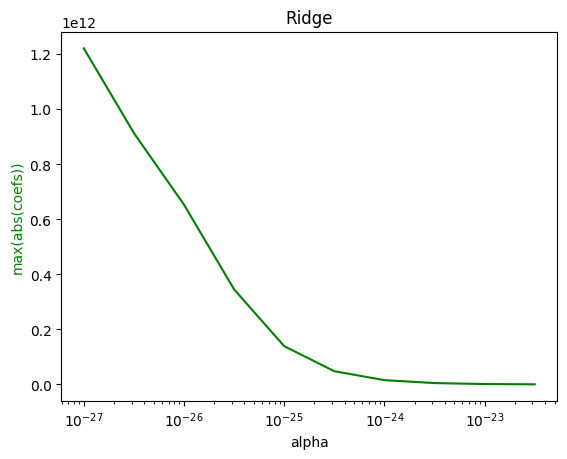

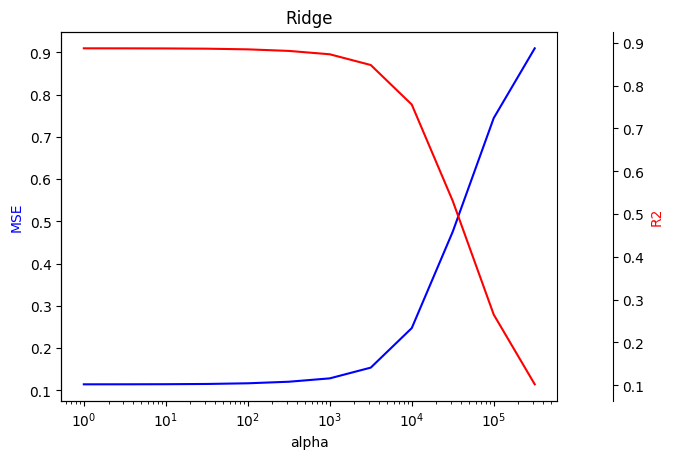

In [44]:
assess_model("Ridge",rid, X_train3, y_train_s, X_test3, y_test_s, [10 ** i for i in np.arange(-27, -22., .5)], False, False)
assess_model("Ridge",rid, X_train3, y_train_s, X_test3, y_test_s, [10 ** i for i in np.arange(0, 6., .5)], True, True, False)

###### End of file - Ignore Remaining Cells ###### 